### Syscoin Supply + Masternode Reward Simulations
* https://etherscan.io/chart/transactionfee

In [1]:
import datetime
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin, minimize
import statsmodels.api as sm
from pymc3.gp.util import plot_gp_dist

### Simulate Prices

In [2]:
def func_exp(x, a, b, c):
    return a * np.exp(b * x) + c

def gen_drift(N):    
    empty_dataset = np.zeros(N)
    mod = sm.tsa.SARIMAX(empty_dataset, order=(1, 1, 1), initialization='diffuse')
    return mod.simulate([0.5, -5/3, 5/6, 4**2], N)

def scale_array(dat, out_range=(-1, 1)):
    domain = [np.min(dat, axis=0), np.max(dat, axis=0)]

    def interp(x):
        return out_range[0] * (1.0 - x) + out_range[1] * x

    def uninterp(x):
        b = 0
        if (domain[1] - domain[0]) != 0:
            b = domain[1] - domain[0]
        else:
            b =  1.0 / domain[1]
        return (x - domain[0]) / b

    return interp(uninterp(dat))

def gen_prices(N, lwr_price, upr_price):
    
    x = range(1,N+1)
    y_trend = np.array([func_exp(e, 1, 0.002,0) for e in x])
    y_trend = scale_array(y_trend, (lwr_price, upr_price))
    drift = scale_array(np.abs(gen_drift(N)), (0, 1))
    sim = lwr_price + y_trend*drift
    
    return sim

In [3]:
# Jun 03 2019 (start)
# supply = 554103161

# June 28th, 2021
# supply 614730694

# Aug 23, 2021 
# supply 617746652

# July 12th, 2022 
# supply 650631036 + 100000000 - 13116676 = 737514361

In [4]:
utxo_supply = 650631037.54678924
nevm_supply = 100000000 - 13116676.320312181517900351
tot_supply = utxo_supply + nevm_supply # July 12th, 2022
tot_supply

737514361.2264771

### Ethereum Transaction Fees
* https://etherscan.io/chart/transactionfee
* last download: July 12th, 2022 

In [5]:
tx_fee = pd.read_csv('../resources/ETHTransactionFee.csv')
tx_fee.columns = ['date', 'timestamp','tx_fee']
tx_fee = tx_fee.assign(tx_fee = [float(tx)/1e18 for tx in tx_fee['tx_fee'].values])
date_split = [t.rstrip().split('/') for t in tx_fee['date'].values]
date_times = [datetime.date(int(t[2]), int(t[0]), int(t[1])) for t in date_split]
tx_fee = tx_fee.assign(date_time = date_times)

In [6]:
INITIAL_SYS_SUPPLY = 614730694.63 # June 28th, 2021
MAX_COINS = 888000000
DAYS_IN_YEAR = 365
ANNUAL_INFLATION = 0.05
DAILY_PERCENTAGE_GRWTH = (1+ANNUAL_INFLATION)**(1/DAYS_IN_YEAR)
LAST_DATE = '2021-06-28 00:00:00'
START_DATE = '2015-11-07 00:00:00'

In [7]:
def supplyNYears(A,t):
    return A*(1.05)**t

def supplyNDays(A,t):
    daysInYr = 366 if isLeapYear(getDate(t, strt_date = LAST_DATE).year) else 365
    return A*(1.05)**(t/365)

In [8]:
def isLeapYear(yr):
    return bool((yr-2000) % 4 == 0) 

def getDate(t, strt_date = START_DATE):
    return datetime.datetime.strptime(strt_date, "%Y-%m-%d %H:%M:%S") + datetime.timedelta(days=t) 

In [9]:
N = 365
STRT_DATE = '2019-06-03 00:00:00'
STRT_SUPPLY = 554103161
STRT_YR = 2019
DEFLATION = 0.05
INITIAL_BLK_REWARD = 151767*12/(365*24*60) + 7.81 + 23.45
NUM_DAILY_BLOCKS = 24*60

def gen_block_rewards(strt_date = STRT_DATE,
                      strt_supply = STRT_SUPPLY,
                      ini_blk_reward = INITIAL_BLK_REWARD,
                      n = N,
                      deflation = DEFLATION,
                      num_daily_blocks = NUM_DAILY_BLOCKS,
                      nevm_rewards = None,
                      pow_rewards = None):
    
    STRT_YR = datetime.datetime.strptime(strt_date, "%Y-%m-%d %H:%M:%S").year
    blk_rewards = [ini_blk_reward]
    dates = np.array([getDate(t, strt_date = strt_date) for t in range(0,n)])
    da = np.array([dates.flatten()[t].day for t in range(0,n)])
    mo = np.array([dates.flatten()[t].month for t in range(0,n)])
    yr = np.array([dates.flatten()[t].year for t in range(0,n)])

    rewards = np.repeat(0.0,n)
    rewards[0] = blk_rewards[0]

    for k in range(1, n):
        diff_yr = yr[k] - yr[k-1]
        diff_mo = mo[k] - mo[k-1]
        rewards[k] = blk_rewards[len(blk_rewards)-1]
        
        if diff_mo == 1:
            blk_reward = blk_rewards[len(blk_rewards)-1]
        
        if diff_yr == 1:
            blk_reward = blk_rewards[len(blk_rewards)-1]
            blk_rewards.append(blk_reward - deflation*blk_reward)

    daily_rewards = rewards*num_daily_blocks       
            
    df = pd.DataFrame({'dates':dates.flatten(),
                       'yr':yr.flatten(),
                       'mo':mo.flatten(),
                       'da':da.flatten(),
                       'blk_reward':rewards,
                       'daily_rewards':daily_rewards,
                       'supply':strt_supply+np.cumsum(daily_rewards)})
    
    if (nevm_rewards != None): 
        df.insert(loc=5, column='nevm_rewards', value=nevm_rewards)

    if (pow_rewards != None): 
        df.insert(loc=6, column='pow_rewards', value=pow_rewards)  
        
    if (nevm_rewards != None) & (pow_rewards != None):
        rewards = rewards + np.repeat(nevm_rewards,n)
        daily_rewards = rewards*num_daily_blocks 
        df = df.assign(daily_rewards=daily_rewards)
          
    return df

### Supply Pre-NEVM

In [10]:
INDEX = 812
SUPPLY_AT_INDEX = 617746652 # Aug 23, 2021 
N_DAYS_TO_NEVM = 917

def objective_function(alpha):
    
    pow_df = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = alpha*38.5,
                           n = N_DAYS_TO_NEVM)
                  
    return abs(SUPPLY_AT_INDEX - pow_df['supply'].iloc[INDEX])

In [11]:
ALPHA_INIT = 1.4872300387520823
result = minimize(objective_function, ALPHA_INIT, method='SLSQP', options={'maxiter': 1000})
alpha_hat = result.x[0]
alpha_hat

1.487230114402233

In [12]:
STRT_DATE = '2019-06-03 00:00:00'
STRT_SUPPLY = 554103161
NUM_DAILY_BLOCKS = 24*60
INITIAL_BLK_REWARD = alpha_hat*38.5

pre_nevm = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           n = N_DAYS_TO_NEVM)

In [13]:
pre_nevm.tail(3)

,dates,yr,mo,da,blk_reward,daily_rewards,supply
914,2021-12-03,2021,12,3,51.675669,74412.963882,6.253368e+08
915,2021-12-04,2021,12,4,51.675669,74412.963882,6.254112e+08
916,2021-12-05,2021,12,5,51.675669,74412.963882,6.254856e+08


### Supply Post-NEVM

In [14]:
N = 12*365+3
STRT_DATE = '2021-12-06 00:00:00'
STRT_SUPPLY = pre_nevm['supply'].iloc[-1]
NUM_DAILY_BLOCKS = 24*60*60 / 150
INITIAL_BLK_REWARD = 2.5*(151767*12/(365*24*60) + 7.81 + 23.45)

nevm_lwr = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           num_daily_blocks = NUM_DAILY_BLOCKS,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 5.27)

In [15]:
N = 12*365+3
STRT_DATE = '2021-12-06 00:00:00'
STRT_SUPPLY = pre_nevm['supply'].iloc[-1]
NUM_DAILY_BLOCKS = 24*60*60 / 150
INITIAL_BLK_REWARD = 2.5*pre_nevm['blk_reward'].iloc[-1]

nevm_med = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           num_daily_blocks = NUM_DAILY_BLOCKS,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 10.55)

In [16]:
N = 12*365+3
STRT_DATE = '2021-12-06 00:00:00'
STRT_SUPPLY = pre_nevm['supply'].iloc[-1]
NUM_DAILY_BLOCKS = 24*60*60 / 150
INITIAL_BLK_REWARD = 2.5*(151767*12/(365*24*60) + 7.81 + 46.9)

nevm_upr = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           num_daily_blocks = NUM_DAILY_BLOCKS,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 10.55)

In [17]:
nevm_df = nevm_lwr.iloc[:, [0,1,2,3]]
nevm_df.insert(loc=4, column='blk_reward_lwr', value=nevm_lwr['blk_reward'].values)
nevm_df.insert(loc=5, column='nevm_rewards_lwr', value=nevm_lwr['nevm_rewards'].values)
nevm_df.insert(loc=6, column='pow_rewards_lwr', value=nevm_lwr['pow_rewards'].values)
nevm_df.insert(loc=7, column='daily_rewards_lwr', value=nevm_lwr['daily_rewards'].values)
nevm_df.insert(loc=8, column='supply_lwr', value=nevm_lwr['supply'].values)

nevm_df.insert(loc=9, column='blk_reward_upr', value=nevm_upr['blk_reward'].values)
nevm_df.insert(loc=10, column='nevm_rewards_upr', value=nevm_upr['nevm_rewards'].values)
nevm_df.insert(loc=11, column='pow_rewards_upr', value=nevm_upr['pow_rewards'].values)
nevm_df.insert(loc=12, column='daily_rewards_upr', value=nevm_upr['daily_rewards'].values)
nevm_df.insert(loc=13, column='supply_upr', value=nevm_upr['supply'].values)

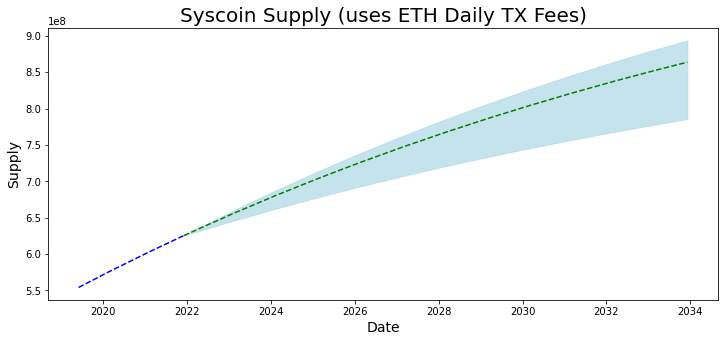

In [18]:
fig = plt.figure(figsize=(12,5))
plt.plot(nevm_med['dates'].values, nevm_med['supply'].values, color='green', linestyle='dashed', label="y_pred")
plt.plot(pre_nevm['dates'].values, pre_nevm['supply'].values, color='blue', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_df['dates'].values, nevm_df['supply_lwr'].values, nevm_df['supply_upr'].values, alpha=0.7, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
plt.ylabel("Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)
fig.savefig('../img/syscoin_daily_supply.png')

### NEVM Supply Predictions

In [19]:
import statsmodels.api as sm

N = 12*365

from statsmodels.stats.outliers_influence import summary_table
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import numpy as np
import random

y = np.log(tx_fee['tx_fee'].values[100:])
x = np.log(np.array(range(1,len(y)+1)))

X = sm.add_constant(x)
regr = sm.OLS(y, X)
fit = regr.fit()
y_hat = fit.fittedvalues
prstd, y_hat_lwr, y_hat_upr = wls_prediction_std(fit)

st, data, ss2 = summary_table(fit, alpha=0.05)

x_new = np.log(np.array(range(2439,2439+N)))
X_p = sm.add_constant(x_new)
pred = fit.get_prediction(X_p)

y_pred = pred.predicted_mean
y_pred_lwr = y_pred - 1.96*prstd[0]
y_pred_upr = y_pred + 1.96*prstd[0]

In [20]:
mc_sim = [np.random.normal(y_pred[k], prstd[0],100) for k in range(0,len(y_pred))]
mc_sim_med = [np.median(mc_sim[k]) for k in range(0,len(y_pred))]
mc_sim_lwr = [np.quantile(mc_sim[k],0.05) for k in range(0,len(y_pred))]
mc_sim_upr = [np.quantile(mc_sim[k],0.95) for k in range(0,len(y_pred))]

In [21]:
sim = mc_sim[0]
for k in range(1,len(y_pred)):
    sim = np.vstack((sim, mc_sim[k]))

In [22]:
dates = [getDate(t) for t in range(0,2439)]
dates_pred = [getDate(t) for t in range(2440,2440+N)]

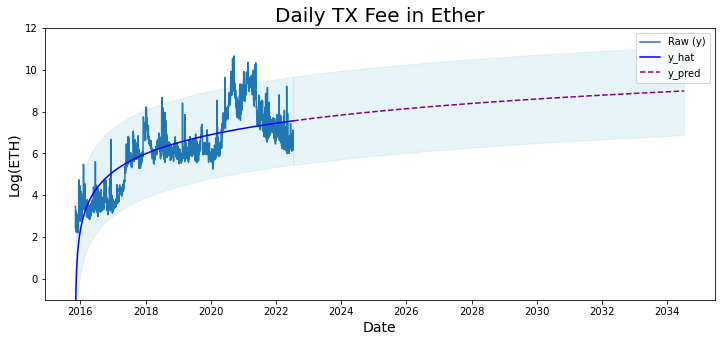

In [23]:
x = np.array(range(1,len(y)+1))
x_pred = np.array(range(2440,2440+N))

fig = plt.figure(figsize=(12,5))
ax = fig.gca()
plt.plot(dates, y, label="Raw (y)")
plt.plot(dates, y_hat, color='blue', label="y_hat")
plt.fill_between(dates, y_hat_lwr, y_hat_upr, alpha=0.3, color='lightblue')

plt.plot(dates_pred, y_pred, color='purple', linestyle='dashed', label="y_pred")
plt.fill_between(dates_pred, y_pred_lwr, y_pred_upr, alpha=0.3, color='lightblue')
plt.title("Daily TX Fee in Ether", fontsize=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Log(ETH)", fontsize=14)
plt.ylim(-1,12)
plt.legend();
fig.savefig('../img/eth_daily_tx_fee.png')

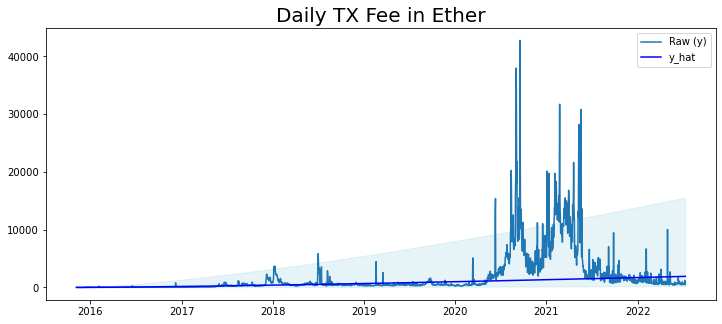

In [24]:
x = np.array(range(1,len(y)+1))
x_pred = np.array(range(2061,2061+N))

fig = plt.figure(figsize=(12,5))
plt.plot(dates, np.exp(y), label="Raw (y)")
plt.plot(dates, np.exp(y_hat), color='blue', label="y_hat")
plt.fill_between(dates, np.exp(y_hat_lwr), np.exp(y_hat_upr), alpha=0.3, color='lightblue')

plt.title("Daily TX Fee in Ether", fontsize=20)
fig.savefig('../img/eth_daily_tx_fee2.png')
plt.legend();

In [25]:
dates_ = np.append(dates, dates_pred[1:])
y_hat_ = np.append(y_hat, y_pred[1:])
y_hat_lwr_ = np.append(y_hat_lwr, y_pred_lwr[1:])
y_pred_upr_ = np.append(y_hat_upr, y_pred_upr[1:])

est_df = pd.DataFrame({'dates':dates_,
                        'pred':np.cumsum(np.exp(y_hat_)),
                        'pred_lwr':np.cumsum(np.exp(y_hat_lwr_)),
                        'pred_upr':np.cumsum(np.exp(y_pred_upr_))})

est_df = est_df.iloc[0:len(nevm_df)]

Text(0.5, 24.0, 'Date')

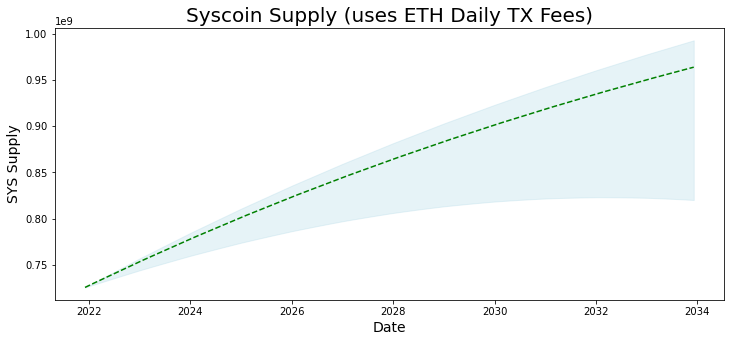

In [26]:
addition_supply = 100000000

coin_supply_upr = addition_supply + nevm_df['supply_upr'].values - est_df['pred_lwr'].values
coin_supply_lwr = addition_supply + nevm_df['supply_lwr'].values - est_df['pred_upr'].values


sys_dates = nevm_med['dates'].values
sys_supply =  addition_supply+nevm_med['supply'].values

fig = plt.figure(figsize=(12,5))
plt.plot(sys_dates, sys_supply, color='green', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_med['dates'].values, coin_supply_lwr, coin_supply_upr, alpha=0.3, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
fig.savefig('../img/syscoin_daily_supply.png')
plt.ylabel("SYS Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)

Text(0.5, 24.0, 'Date')

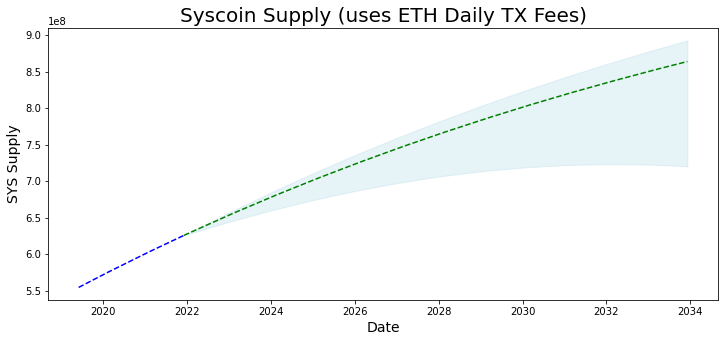

In [27]:
coin_supply_upr = nevm_df['supply_upr'].values - est_df['pred_lwr'].values
coin_supply_lwr = nevm_df['supply_lwr'].values - est_df['pred_upr'].values

fig = plt.figure(figsize=(12,5))
plt.plot(nevm_med['dates'].values, nevm_med['supply'].values, color='green', linestyle='dashed', label="y_pred")
plt.plot(pre_nevm['dates'].values, pre_nevm['supply'].values, color='blue', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_med['dates'].values, coin_supply_lwr, coin_supply_upr, alpha=0.3, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
fig.savefig('../img/syscoin_daily_supply.png')
plt.ylabel("SYS Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)

In [28]:
pred_df = pd.DataFrame({'dates': nevm_med['dates'].values,
                        'pred':addition_supply + nevm_med['supply'].values,
                        'pred_lwr':addition_supply + coin_supply_lwr,
                        'pred_upr':addition_supply + coin_supply_upr})

In [29]:
nevm_df

,dates,yr,mo,da,blk_reward_lwr,nevm_rewards_lwr,pow_rewards_lwr,daily_rewards_lwr,supply_lwr,blk_reward_upr,nevm_rewards_upr,pow_rewards_upr,daily_rewards_upr,supply_upr
0,2021-12-06,2021,12,6,86.81250,10.55,5.27,56080.800000,6.255356e+08,145.43750,10.55,10.55,89848.800000,6.255694e+08
1,2021-12-07,2021,12,7,86.81250,10.55,5.27,56080.800000,6.255856e+08,145.43750,10.55,10.55,89848.800000,6.256531e+08
2,2021-12-08,2021,12,8,86.81250,10.55,5.27,56080.800000,6.256356e+08,145.43750,10.55,10.55,89848.800000,6.257369e+08
3,2021-12-09,2021,12,9,86.81250,10.55,5.27,56080.800000,6.256856e+08,145.43750,10.55,10.55,89848.800000,6.258207e+08
4,2021-12-10,2021,12,10,86.81250,10.55,5.27,56080.800000,6.257356e+08,145.43750,10.55,10.55,89848.800000,6.259045e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4378,2033-12-01,2033,12,1,46.91001,10.55,5.27,33096.965823,7.854972e+08,78.58862,10.55,10.55,51343.845264,8.935540e+08
4379,2033-12-02,2033,12,2,46.91001,10.55,5.27,33096.965823,7.855242e+08,78.58862,10.55,10.55,51343.845264,8.935993e+08
4380,2033-12-03,2033,12,3,46.91001,10.55,5.27,33096.965823,7.855512e+08,78.58862,10.55,10.55,51343.845264,8.936445e+08
4381,2033-12-04,2033,12,4,46.91001,10.55,5.27,33096.965823,7.855783e+08,78.58862,10.55,10.55,51343.845264,8.936898e+08


In [30]:
mo = pd.to_datetime(pred_df['dates'].values).month
da = pd.to_datetime(pred_df['dates'].values).day

indices = []
m = 0
for k in range(0,len(pred_df)):
    if((mo[k] == 1) & (da[k] == 1)): indices.append(k)
    
pred_df.iloc[indices]

,dates,pred,pred_lwr,pred_upr
26,2022-01-01,7.274948e+08,7.268354e+08,7.277474e+08
391,2023-01-01,7.532974e+08,7.439737e+08,7.567923e+08
756,2024-01-01,7.778100e+08,7.596786e+08,7.843763e+08
1122,2025-01-01,8.011607e+08,7.738528e+08,8.106408e+08
1487,2026-01-01,8.232833e+08,7.863329e+08,8.355096e+08
1852,2027-01-01,8.442998e+08,7.970949e+08,8.591184e+08
2217,2028-01-01,8.642654e+08,8.060879e+08,8.815281e+08
2583,2029-01-01,8.832847e+08,8.132426e+08,9.028556e+08
2948,2030-01-01,9.013037e+08,8.184441e+08,9.230400e+08
3313,2031-01-01,9.184218e+08,8.217405e+08,9.421912e+08


### Price simulations

In [69]:
N = 5*365 + 27
LWR_SYS_PRICE = 0.25
UPR_SYS_PRICE = 25

price_sim = gen_prices(N, LWR_SYS_PRICE, UPR_SYS_PRICE).reshape(-1,1)
for k in range(1,50):
    sim = gen_prices(N, LWR_SYS_PRICE, UPR_SYS_PRICE).reshape(-1,1)
    price_sim = np.hstack((price_sim,sim))

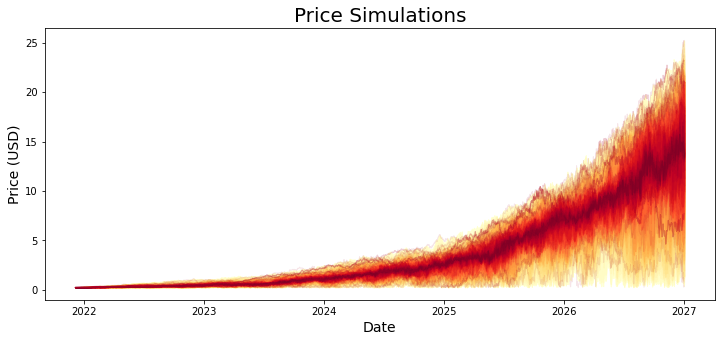

In [72]:
start = datetime.datetime(2021, 12, 6, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(days=i) for i in range(N)])    
    
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, price_sim.transpose(), date_times, palette="YlOrRd")
plt.ylabel("Price (USD)", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Price Simulations", fontsize=20)
fig.savefig('../img/price_simulations.png')

### Rewards simulations

In [73]:
pred_dates = nevm_df['dates'].values
daily_rewards_lwr = nevm_df['daily_rewards_lwr'].values
daily_rewards_mu = nevm_med['daily_rewards'].values
daily_rewards_upr = nevm_df['daily_rewards_lwr'].values

In [74]:
N = 5*365 + 27
price_sim = gen_prices(N, LWR_SYS_PRICE, UPR_SYS_PRICE)
prices_sim = price_sim.reshape(-1,1)
reward_sim = price_sim*daily_rewards_mu[0:N]
reward_sim = reward_sim.reshape(-1,1)
for k in range(1,50):
    price_sim = gen_prices(N, LWR_SYS_PRICE, UPR_SYS_PRICE)
    prices_sim = np.hstack((prices_sim,price_sim.reshape(-1,1)))
    sim_med = price_sim*daily_rewards_mu[0:N]  
    sim_med = sim_med.reshape(-1,1)
    reward_sim = np.hstack((reward_sim,sim_med))

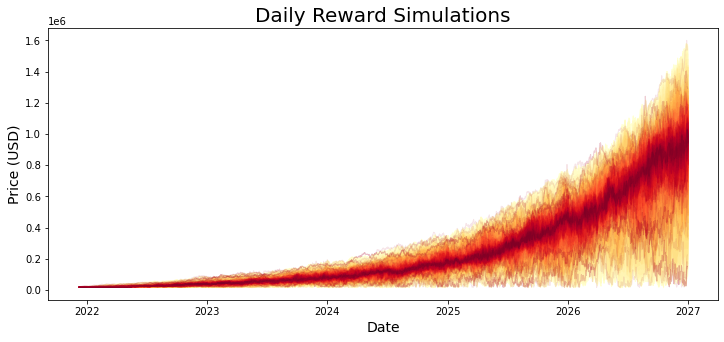

In [75]:
start = datetime.datetime(2021, 12, 6, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(days=i) for i in range(N)])    
    
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, reward_sim.transpose(), date_times, palette="YlOrRd")
plt.ylabel("Price (USD)", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Daily Reward Simulations", fontsize=20)
fig.savefig('../img/reward_simulations.png')

In [76]:
reward_mu = [np.quantile(reward_sim[0], 0.5)]
reward_lwr = [np.quantile(reward_sim[0], 0.05)]
reward_upr = [np.quantile(reward_sim[0], 0.95)]

price_mu = [np.quantile(prices_sim[0], 0.5)]
price_lwr = [np.quantile(prices_sim[0], 0.05)]
price_upr = [np.quantile(prices_sim[0], 0.95)]

for day in range(1,N):
    reward_mu.append(np.quantile(reward_sim[day], 0.5))
    reward_lwr.append(np.quantile(reward_sim[day], 0.05))
    reward_upr.append(np.quantile(reward_sim[day], 0.95))
    
    price_mu.append(np.quantile(prices_sim[day], 0.5))
    price_lwr.append(np.quantile(prices_sim[day], 0.05))
    price_upr.append(np.quantile(prices_sim[day], 0.95))    

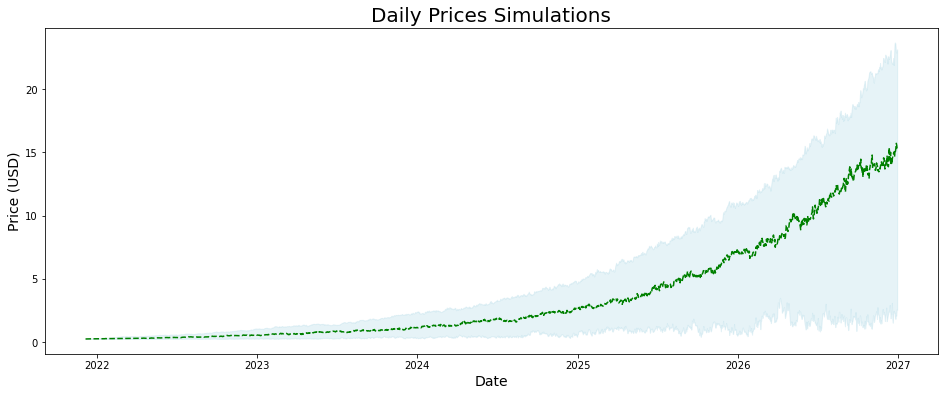

In [77]:
fig = plt.figure(figsize=(16, 6))
ax = fig.gca()
plt.plot(date_times, price_mu, color='green', linestyle='dashed', label="y_pred")
plt.fill_between(date_times, price_lwr, price_upr, alpha=0.3, color='lightblue')
plt.ylabel("Price (USD)", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Daily Prices Simulations", fontsize=20)
fig.savefig('../img/reward_simulations.png')

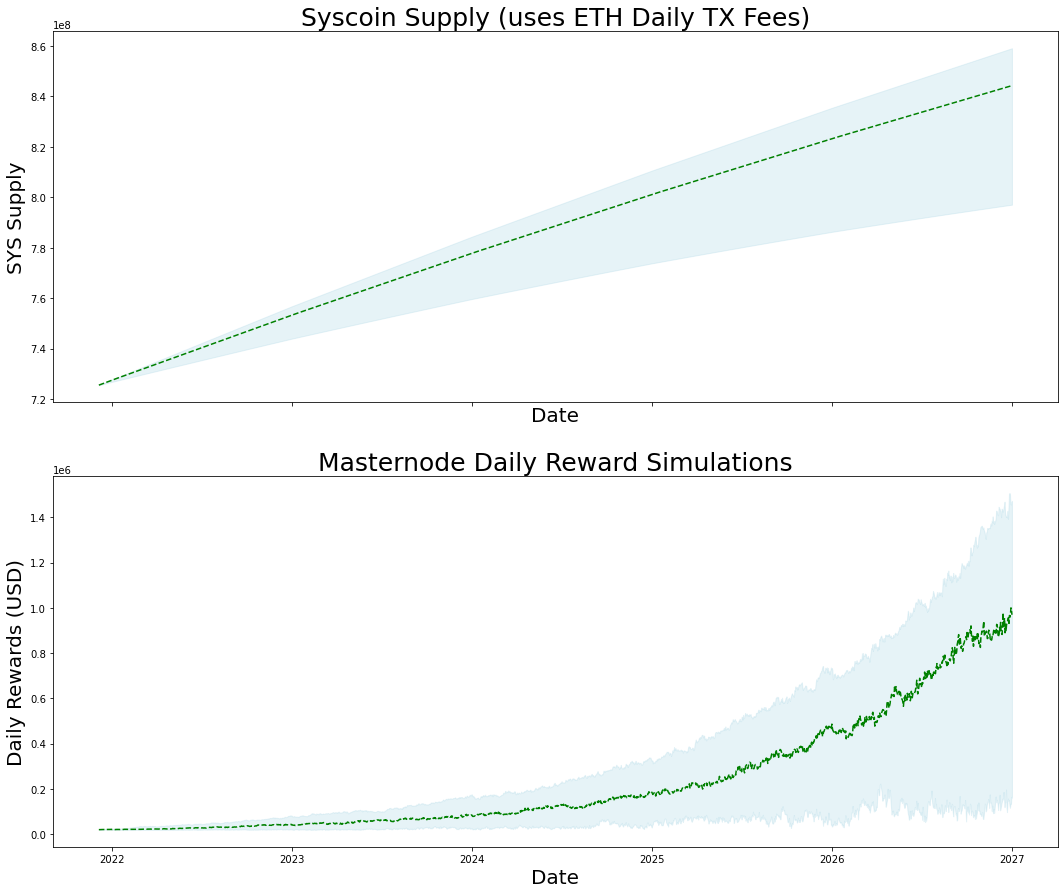

In [78]:
fig, (s_ax, r_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(18, 15))

sys_supply =  100000000+nevm_med['supply'].values[0:N]
sys_supply_lwr =  100000000+coin_supply_lwr[0:N]
sys_supply_upr =  100000000+coin_supply_upr[0:N]

s_ax.plot(date_times, sys_supply, color='green', linestyle='dashed', label="y_pred")
s_ax.fill_between(date_times, sys_supply_lwr, sys_supply_upr, alpha=0.3, color='lightblue')
s_ax.set_title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=25)
s_ax.set_ylabel("SYS Supply", fontsize=20)
s_ax.set_xlabel("Date", fontsize=20)

r_ax.fill_between(date_times, reward_lwr, reward_upr, alpha=0.3, color='lightblue')
r_ax.plot(date_times, reward_mu, color='green', linestyle='dashed', label="y_pred")
r_ax.set_ylabel("Daily Rewards (USD)", fontsize=20)
r_ax.set_xlabel("Date", fontsize=20)
r_ax.set_title("Masternode Daily Reward Simulations", fontsize=25)
fig.savefig('../img/supply_mn_reward_simulations.png')


In [81]:
dat = {
    'date' : date_times,
    'year' : [date_times[k].year for k in range(N)],
    'month' : [date_times[k].month for k in range(N)],    
    'nsys' : sys_supply,
    'nsys_lwr' : sys_supply_lwr,
    'nsys_upr' : sys_supply_upr,
    'price' : price_mu,
    'price_lwr' : price_lwr,
    'price_upr' : price_upr,    
    'reward' : reward_mu,
    'reward_lwr' : reward_lwr,
    'reward_upr' : reward_upr,
    'm_nodes' : scale_array(np.array(range(1,N+1)), out_range=(2500, 2900))
}
  
proj = pd.DataFrame(dat)
proj = proj.set_index('date')

In [82]:
proj_aggr = pd.DataFrame(proj.groupby([(proj.index.year), (proj.index.month)])['nsys'].median())
proj_aggr['nsys_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['nsys_lwr'].median().values
proj_aggr['nsys_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['nsys_upr'].median().values
proj_aggr['reward'] = proj.groupby([(proj.index.year), (proj.index.month)])['reward'].sum().values
proj_aggr['reward_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['reward_lwr'].sum().values
proj_aggr['reward_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['reward_upr'].sum().values
proj_aggr['price'] = proj.groupby([(proj.index.year), (proj.index.month)])['price'].median().values
proj_aggr['price_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['price_lwr'].median().values
proj_aggr['price_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['price_upr'].median().values
proj_aggr['m_nodes'] = proj.groupby([(proj.index.year), (proj.index.month)])['m_nodes'].max().values

In [83]:
proj_aggr.index.names = ['year','month']
proj_aggr.reset_index(level=['year', 'month'], inplace=True)

In [84]:
proj_aggr

,year,month,nsys,nsys_lwr,nsys_upr,reward,reward_lwr,reward_upr,price,price_lwr,price_upr,m_nodes
0,2021,12,7.264902e+08,7.261606e+08,7.266165e+08,5.421864e+05,5.253895e+05,5.967905e+05,0.260376,0.251088,0.291297,2505.402485
1,2022,1,7.285551e+08,7.275473e+08,7.289412e+08,6.510385e+05,6.020171e+05,7.835531e+05,0.273354,0.252060,0.328752,2512.101567
2,2022,2,7.306406e+08,7.289461e+08,7.312889e+08,6.106505e+05,5.462868e+05,8.760726e+05,0.283869,0.253924,0.408273,2518.152350
3,2022,3,7.327260e+08,7.303431e+08,7.336365e+08,6.963698e+05,6.048590e+05,1.103867e+06,0.293058,0.254726,0.465111,2524.851432
4,2022,4,7.348821e+08,7.317850e+08,7.360637e+08,7.037440e+05,5.865228e+05,1.110770e+06,0.304781,0.254397,0.482974,2531.334414
...,...,...,...,...,...,...,...,...,...,...,...,...
56,2026,8,8.363538e+08,7.931465e+08,8.501942e+08,2.357584e+07,3.499194e+06,3.421164e+07,11.924053,1.732009,17.474818,2873.635873
57,2026,9,8.381100e+08,7.940320e+08,8.521668e+08,2.492105e+07,3.282564e+06,3.468733e+07,13.084072,1.750140,18.074161,2880.118855
58,2026,10,8.398662e+08,7.949103e+08,8.541392e+08,2.706686e+07,3.056803e+06,3.951189e+07,13.752791,1.523801,19.977920,2886.817936
59,2026,11,8.416223e+08,7.957812e+08,8.561116e+08,2.665411e+07,3.665722e+06,4.087039e+07,13.961392,2.017028,21.275797,2893.300918


In [85]:
M_NODE_SHARE = 0.34
N_NODES = 200
proj_aggr_mnodes = copy.copy(proj_aggr)
n_nodes = proj_aggr['m_nodes'].values

In [86]:
proj_aggr_mnodes['reward'] = N_NODES*M_NODE_SHARE*proj_aggr_mnodes['reward'].values/n_nodes
proj_aggr_mnodes['reward_lwr'] = N_NODES*M_NODE_SHARE*proj_aggr_mnodes['reward_lwr'].values/n_nodes
proj_aggr_mnodes['reward_upr'] = N_NODES*M_NODE_SHARE*proj_aggr_mnodes['reward_upr'].values/n_nodes
proj_aggr_mnodes['m_nodes'] = N_NODES
proj_aggr_mnodes

,year,month,nsys,nsys_lwr,nsys_upr,reward,reward_lwr,reward_upr,price,price_lwr,price_upr,m_nodes
0,2021,12,7.264902e+08,7.261606e+08,7.266165e+08,14715.669731,14259.780195,1.619770e+04,0.260376,0.251088,0.291297,200
1,2022,1,7.285551e+08,7.275473e+08,7.289412e+08,17622.942232,16295.981116,2.120997e+04,0.273354,0.252060,0.328752,200
2,2022,2,7.306406e+08,7.289461e+08,7.312889e+08,16489.961306,14751.888128,2.365740e+04,0.283869,0.253924,0.408273,200
3,2022,3,7.327260e+08,7.303431e+08,7.336365e+08,18754.824490,16290.231883,2.972964e+04,0.293058,0.254726,0.465111,200
4,2022,4,7.348821e+08,7.317850e+08,7.360637e+08,18904.887987,15755.937997,2.983896e+04,0.304781,0.254397,0.482974,200
...,...,...,...,...,...,...,...,...,...,...,...,...
56,2026,8,8.363538e+08,7.931465e+08,8.501942e+08,557884.622470,82802.836057,8.095639e+05,11.924053,1.732009,17.474818,200
57,2026,9,8.381100e+08,7.940320e+08,8.521668e+08,588389.408070,77501.781898,8.189725e+05,13.084072,1.750140,18.074161,200
58,2026,10,8.398662e+08,7.949103e+08,8.541392e+08,637569.288851,72004.060533,9.307163e+05,13.752791,1.523801,19.977920,200
59,2026,11,8.416223e+08,7.957812e+08,8.561116e+08,626440.132595,86153.873036,9.605591e+05,13.961392,2.017028,21.275797,200


In [87]:
import os
os.getcwd()

'/Users/ian_moore/repos/syscoin_research/notebooks'

In [88]:
proj_aggr.to_csv('../img/proj_aggr.csv')
proj_aggr_mnodes.to_csv('../img/proj_aggr_mnodes.csv')